# Exercise 1
For the Boston housing dataset (https://raw.githubusercontent.com/kannansingaravelu/datasets/main/boston.csv), construct a dataframe with all features and target values. Perform feature selection to choose the most appropriate features using

1. Variance Inflation Factor
2. SelectKBest
3. Recursive Feature Elimination
4. Recursive Feature Elimination Cross validation
5. Shapley Additive Explanations

Fit the regressor and compare the results. How much better does the model perform? Use `scikit-learn` package to perform this task.

# Solution

### Features Selection

Feature selection methods are approaches to reduce the number of input variables that are believed to be most useful to a model. 

**It is primarily focused on removing non-informative or redundant predictors from the model**. 

We’ll focus on five methods in relation to linear regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

import shap

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/kannansingaravelu/datasets/main/boston.csv")
#df = pd.read_csv("M4E4_boston.csv")
df.columns = df.columns.str.upper()

X = df.drop('MEDV', axis = 1)
y = df['MEDV']

In [6]:
scaler = StandardScaler()

# pipe in a stream
# 1. standardise dataset
# 2. run linear reg
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())
])

In [7]:
pipe.fit(X,y)

y_pred = pipe.predict(X)

print(y_pred[:10])
print(f'R^2: {pipe.score(X,y):0.4}')
rbase = pipe.score(X,y)

[30.00384338 25.02556238 30.56759672 28.60703649 27.94352423 25.25628446
 23.00180827 19.53598843 11.52363685 18.92026211]
R^2: 0.7406


#### Method 1: Multicollinearity VIF

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. This means that an independent variable can be predicted from another independent variable in a regression model.

Multicollinearity can be detected using various methods and one such method is Variable Inflation Factors (VIF). VIF determines the strength of the correlation between the independent variables (It is predicted by taking a variable and regressing it against every other variable).

VIF score of an independent variable represents how well the variable is explained by other independent variables.

>For example, for a set of regressors $X_1, X_2, \cdots, X_k$. 
> We run $X_1$ on $X_2, X_3, \cdots, X_k$
>, and run $X_2$ on $X_1, X_3, \cdots, X_k$
>, repetitively.

$R^2$ value is determined to find out how well an independent variable is described by the other independent variables. A high value of $R^2$ means that the variable is highly correlated with the other variables. This is captured by the VIF which is denoted below:

$$VIF = \frac{1}{1-R^2}$$

- VIF starts at 1 and has no upper limit.
- VIF = 1, no correlation between the independent variable and the other variables.
- VIF exceeding 5 or 10 indicates high multicollinearity betwen this independent variable and the others.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(X):
    # standardise the dataset
    xs = scaler.fit_transform(X)
    
    # subsume into a Dataframe
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF_Factor'] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    
    return vif

vif(X).round(2).sort_values(by='VIF_Factor')

,Feature,VIF_Factor
3,CHAS,1.07
11,B,1.35
0,CRIM,1.79
10,PTRATIO,1.80
5,RM,1.93
1,ZN,2.30
12,LSTAT,2.94
6,AGE,3.10
7,DIS,3.96
2,INDUS,3.99


In [18]:
# we find TAX & RAD might be highly correlated and might result in multicollinearity
newX = X.drop(['TAX','RAD'], axis = 1)

temp = vif(newX).sort_values(by = 'VIF_Factor')
temp

,Feature,VIF_Factor
3,CHAS,1.057805
9,B,1.316559
0,CRIM,1.478206
8,PTRATIO,1.496077
5,RM,1.872532
1,ZN,2.154483
10,LSTAT,2.936487
6,AGE,3.075755
2,INDUS,3.179166
4,NOX,3.901348


In [10]:
# Filter the first six features

X_method1 = X[temp['Feature'].values[:6]]

In [11]:
# reg X_method1 on y
# X_method1 is when exclude multicollinearity
pipe.fit(X_method1, y)

y_pred1 = pipe.predict(X_method1)

print(y_pred1[:10])
print(f'R^2: {pipe.score(X_method1, y):0.4}')
r1 = pipe.score(X_method1, y)

[28.57799551 24.78825544 30.16715122 28.03678666 29.13085894 23.98038835
 24.50415657 25.65810523 21.62521274 24.29070206]
R^2: 0.6273


#### Method 2: SelectKBest

Select features according to the $k$ highest scores. Univariate feature selection works by selecting the best features based on univariate statistical tests.

`SelectKBest` is used to select `k` number of varialbes that have highest scores.

`f_regression` is used to calculate the F-statistics of each var in X on y. `f_regression` is the **score function** for `SelectKBest`.

In [12]:
from sklearn.feature_selection import (f_regression,  # ANOVA F-value between label/feature for classification tasks
                                       SelectKBest, 
                                       SelectPercentile)

In [13]:
# initialise the class
method2 = SelectKBest(f_regression, k=6)

# fit the model
method2.fit(X,y)

# Iterate the score 
for f, s in zip(X.columns, method2.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 89.49 for feature CRIM
F-score: 75.26 for feature ZN
F-score: 154.0 for feature INDUS
F-score: 15.97 for feature CHAS
F-score: 112.6 for feature NOX
F-score: 471.8 for feature RM
F-score: 83.48 for feature AGE
F-score: 33.58 for feature DIS
F-score: 85.91 for feature RAD
F-score: 141.8 for feature TAX
F-score: 175.1 for feature PTRATIO
F-score: 63.05 for feature B
F-score: 601.6 for feature LSTAT


In [19]:
# Show selected features
print(method2.get_support(indices=True))

[ 2  4  5  9 10 12]


In [20]:
# Filter six features with highest score
X_method2 = X[['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']]

In [21]:
# use those selected features to run the fit/train model 
pipe.fit(X_method2, y) 

# predict labels 
y_pred = pipe.predict(X_method2) 

print(y_pred[:10]) 
print(f'R^2: {pipe.score(X_method2, y):0.4}')
r2 = pipe.score(X_method2, y)

[30.57014999 26.10398705 32.45084162 31.0219246  30.41087418 27.1380861
 24.46192059 21.5381886  13.13415681 21.87515864]
R^2: 0.681


In [22]:
# check the coefficients 
pipe['regressor'].coef_

array([ 0.59754458, -0.39395547,  3.26810054, -0.48846049, -1.9764135 ,
       -3.89469824])

#### Method 3: RFE

Feature ranking with **Recursive Feature Elimination (RFE)**. The goal is to select features by recursively considering smaller and smaller sets of features.

In [23]:
# Feature Selection using RFE 
from sklearn.feature_selection import RFE

In [24]:
# Method 3 
method3 = RFE(LinearRegression(), n_features_to_select=6, step=1) 
method3.fit(X,y)

# Check the selected position, we select 6 features
print(method3.support_)

# Get the feature ranking 
print(method3.ranking_)

[False False False  True  True  True False  True False False  True False
  True]
[3 5 4 1 1 1 8 1 2 6 1 7 1]


In [26]:
# Select Six Features
min_value = min(method3.ranking_)
col = [i for i, x in enumerate(method3.ranking_) if x == min_value]
col

[3, 4, 5, 7, 10, 12]

In [27]:
# Select Six Features
min_value = min(method3.ranking_) 

# Select if the ranking == 1, as the target features
col = [i for i, x in enumerate(method3.ranking_) if x == min_value] 
col

[3, 4, 5, 7, 10, 12]

In [29]:
# Filter selected features 
X_method3 = X[X.columns[col]]

# show those features
X.columns[col]

Index(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')

In [30]:
# fit/train model 
pipe.fit(X_method3, y)

# predict labels 
y_pred3 = pipe.predict(X_method3) 

print(y_pred3[:10])
print(f'R^2: {pipe.score(X_method3, y):0.4}')
r3 = pipe.score(X_method3, y)

[31.0142456  25.79278275 31.84611084 29.74856961 28.99930186 26.11951419
 23.13348366 19.51563196 10.99759368 19.25866209]
R^2: 0.7158


In [31]:
# check the coefficients 
pipe['regressor'].coef_

array([ 0.82321941, -2.16945087,  2.88617319, -2.40778286, -2.16874483,
       -4.06526959])

#### Method 4: RFECV

RFECV means Recursive Feature Elimination with Cross-Validation.

A recursive feature elimination with automatic tuning of the number of features selected with cross-validation.

In [32]:
from sklearn.feature_selection import RFECV

# Method 4 
method4 = RFECV(LinearRegression(), cv=10) 
method4.fit(X,y)

RFECV(cv=10, estimator=LinearRegression())

In [33]:
# Get the selected features with CV 
print(method4.n_features_)

# Get the index of the selected features 
print(method4.get_support(indices=True))

# Check the selected position 
print(method4.support_)

# Get the feature ranking 
print(method4.ranking_)

# # Select Six Features 
# min_value = min(method4.ranking_) 
# col = [i for i, x in enumerate(method4.ranking_) if x == min_value] 
# col

6
[ 3  4  5  7 10 12]
[False False False  True  True  True False  True False False  True False
  True]
[3 5 4 1 1 1 8 1 2 6 1 7 1]


In [34]:
# Filter selected features 
X_method4 = X[X.columns[col]]

print(X.columns[col])

Index(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


In [35]:
# fit/train model 
pipe.fit(X_method4, y)

# predict labels 
y_pred4 = pipe.predict(X_method4)

print(y_pred4[:10]) 
print(f'R^2: {pipe.score(X_method4, y):0.4}')
r4 = pipe.score(X_method4, y)

[31.0142456  25.79278275 31.84611084 29.74856961 28.99930186 26.11951419
 23.13348366 19.51563196 10.99759368 19.25866209]
R^2: 0.7158


In [36]:
# check the coefficients 
pipe['regressor'].coef_

array([ 0.82321941, -2.16945087,  2.88617319, -2.40778286, -2.16874483,
       -4.06526959])

#### Method 5: SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

Shapley values are a widely used approach from cooperative game theory that come with desirable properties and is the average marginal contribution of a feature value across all possible coalitions.

In [37]:
# 100 instances for use as the background distribution 
X100 = shap.utils.sample(X, 100, random_state=42) 
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [38]:
# compute the SHAP values for the linear model 
explainer = shap.Explainer(pipe.predict, X100) 
shap_values = explainer(X)

PermutationExplainer explainer: 507it [00:16, 14.33it/s]                                                               


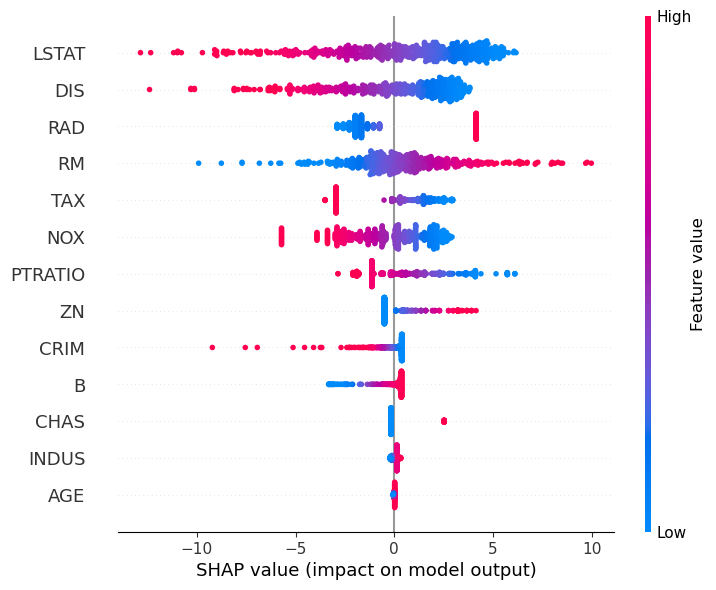

In [39]:
shap.plots.beeswarm(shap_values, max_display=20)

The above plot shows the feature importance of a linear model, where the variables are ranked in descending order and the horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

- Color shows whether that variable is high (in red) or low (in blue) for that observation.
- A high level has a high and positive impact on the quality rating.
- Impact is shown on the X-axis.

In [40]:
# Filter selected features 
X_method5 = X[['LSTAT', 'DIS', 'RM', 'PTRATIO', 'CRIM']]

In [41]:
# use those selected features into the linear regression
# fit/train model 
pipe.fit(X_method5, y)

# predict labels

y_pred5 = pipe.predict(X_method5)

print(y_pred5[:10]) 
print(f'R^2: {pipe.score(X_method5, y):0.4}')
r5 = pipe.score(X_method5, y)

[31.63761273 25.5236182  32.0243847  30.38600726 29.5358719  26.50795486
 23.71933951 19.96956586 10.8068779  20.1215183 ]
R^2: 0.6958


## Comparison

Given the boston housing dataset is a processed data, there seems to be no improvement in the score on feature reduction.

Alternatively, one might split the data into train and test sets to study the impact of over or under fitting of the model. The Recursive Feature Elimination is closer to the original scoring with just six features while the impact of each of these features is explained by the SHAP values.

In [56]:
df_show = pd.DataFrame()
df_show['Feature Selection Method'] = ['Original', 
                                       'VIF', 
                                       'SelectKBest', 
                                       'RFE', 
                                       'RFECV', 
                                       'SHAP']
df_show['R_Squared'] = np.round([rbase, r1, r2, r3, r4, r5],4)
df_show.index = df_show['Feature Selection Method']
df_show = df_show.drop('Feature Selection Method', axis = 1)
df_show['Improvement'] = df_show.R_Squared.pct_change()
df_show

,R_Squared,Improvement
Feature Selection Method,,
Original,0.7406,NaN
VIF,0.6273,-0.152984
SelectKBest,0.6810,0.085605
RFE,0.7158,0.051101
RFECV,0.7158,0.000000
SHAP,0.6958,-0.027941


# References

* Scikit-learn features selection
* SHAP documentation
* Scikit-learn classes reference
* Python resources